# Problem Statement:
The objective of this analysis is to understand key factors influencing app success on the Google Play Store. This includes identifying patterns in ratings, reviews, pricing strategies, and installs to provide insights for app developers and businesses.


# Goals:
Analyze app ratings and reviews to determine quality indicators.

Understand pricing strategies (free vs. paid apps) and their impact on downloads.

Identify popular app categories based on installs and ratings.

Examine the effect of app size, updates, and Android version compatibility on performance.

#Features
The dataset contains details of various apps from the Google Play Store, including:

App Name

Category

Rating

Reviews

Size

Installs

Type (Free or Paid)

Price

Content Rating

Genres

Last Updated

Current Version

Android Version

# Target Variable
Virality Score (a custom metric engineered to reflect user engagement, popularity, and growth)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


# Understand the data

In [ ]:
# Load dataset
df = pd.read_csv("googleplaystore.csv")

# Display first few rows
df.head()


NameError: name 'pd' is not defined

#  Data Cleaning
Removed duplicates (e.g., multiple entries of Facebook, WhatsApp, Instagram)

Converted installs, size, price into numerical formats

Handled missing values in Rating, Size, Android Version

In [ ]:
# Remove duplicates
df.drop_duplicates(inplace=True)

# Remove NaN values
df.dropna(inplace=True)


In [ ]:
# Remove non-numeric characters and convert to numeric
df['Installs'] = df['Installs'].str.replace(r'[\+,]', '', regex=True).astype(float)
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')
df['Size'] = df['Size'].str.replace(r'[^0-9]', '', regex=True)  # Remove non-numeric characters
df['Size'] = pd.to_numeric(df['Size'], errors='coerce')  # Convert to float
df['Price'] = df['Price'].str.replace(r'[\$,]', '', regex=True).astype(float)  # Remove $ and convert



# Feature Engineering
Created new features to quantify app virality:

✅ Engagement Score
Measures how engaging an app is based on reviews and installs:

Engagement Score
=
Reviews
Installs
×
100
Engagement Score=
Installs
Reviews
​
 ×100

✅ Virality Score A custom metric to quantify virality based on reviews, installs, and ratings:

Virality Score
=
log
⁡
(
Reviews
)
×
Rating
log
⁡
(
Installs
)
Virality Score=
log(Installs)
log(Reviews)×Rating
​



In [ ]:
import numpy as np

# Apply log transformation to scale down large values
df['Virality Score'] = (np.log1p(df['Installs']) + np.log1p(df['Reviews'])) / \
                              (np.log1p(df['Size']) + (1 + df['Price']))

# Display top apps based on User Engagement Index
df[['App', 'Category', 'Installs', 'Reviews', 'Size', 'Price', 'Virality Score']] \
  .sort_values(by='Virality Score', ascending=False) \
  .head(10)


,App,Category,Installs,Reviews,Size,Price,Virality Score
2544,Facebook,SOCIAL,1.000000e+09,78158306,0.0,0.0,38.897513
3943,Facebook,SOCIAL,1.000000e+09,78128208,0.0,0.0,38.897128
336,WhatsApp Messenger,COMMUNICATION,1.000000e+09,69119316,0.0,0.0,38.774611
3904,WhatsApp Messenger,COMMUNICATION,1.000000e+09,69109672,0.0,0.0,38.774471
2604,Instagram,SOCIAL,1.000000e+09,66577446,0.0,0.0,38.737142
2545,Instagram,SOCIAL,1.000000e+09,66577313,0.0,0.0,38.737140
3909,Instagram,SOCIAL,1.000000e+09,66509917,0.0,0.0,38.736127
382,Messenger – Text and Video Chat for Free,COMMUNICATION,1.000000e+09,56646578,0.0,0.0,38.575608
335,Messenger – Text and Video Chat for Free,COMMUNICATION,1.000000e+09,56642847,0.0,0.0,38.575542
3665,YouTube,VIDEO_PLAYERS,1.000000e+09,25655305,0.0,0.0,37.783527


In [ ]:
df['Engagement Score'] = (np.log1p(df['Reviews']) / np.log1p(df['Installs'] + 1)) * df['Rating']


In [ ]:
from sklearn.preprocessing import RobustScaler

features = ['Virality Score', 'Engagement Score', 'Rating', 'Reviews', 'Installs']
scaler = RobustScaler()
df_scaled = scaler.fit_transform(df[features])



In [ ]:

df['Virality Score'].value_counts()

,count
Virality Score,
1.882699,4
2.414592,3
2.267770,3
1.570113,3
1.590795,3
...,...
4.561667,1
5.062910,1
23.956874,1


In [ ]:
df['Installs'] = np.log1p(df['Installs'])
df['Reviews'] = np.log1p(df['Reviews'])
df['Size'] = np.log1p(df['Size'])  # Normalize "Size" too


# Clustering with K-Means
Used K-Means Clustering to group apps into virality clusters:

Applied Elbow Method to determine optimal k (number of clusters).

Scaled features before clustering.

Clustered apps into distinct groups representing different virality levels (e.g., High, Medium, Low).

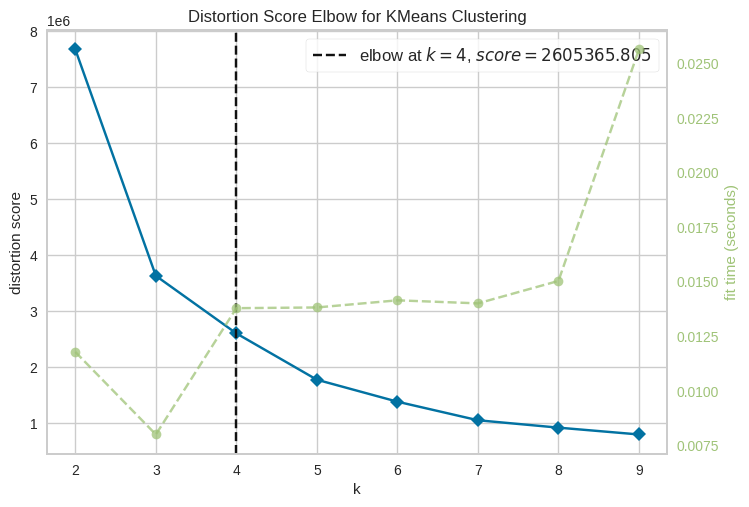

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10))
visualizer.fit(df_scaled)
visualizer.show()

In [ ]:
kmeans = KMeans(n_clusters=5, max_iter=500, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)


In [ ]:
df['Cluster'].value_counts()


,count
Cluster,
3,8517
0,269
4,70
1,21
2,9


In [ ]:
cluster_labels = {0: 'Highly Viral 🚀', 1: 'Moderately Popular 📈', 2: 'Low Engagement 📉'}

# Map cluster labels
df['Cluster Label'] = df['Cluster'].map(cluster_labels)

# Check if mapping was successful
df['Cluster Label'].unique()



array([nan, 'Highly Viral 🚀', 'Low Engagement 📉', 'Moderately Popular 📈'],
      dtype=object)

In [ ]:
df['Cluster'].value_counts()


,count
Cluster,
3,8517
0,269
4,70
1,21
2,9


In [ ]:
cluster_labels = {0: 'Highly Viral 🚀', 1: 'Moderately Popular 📈', 2: 'Low Engagement 📉'}

df['Cluster Label'] = df['Cluster'].map(cluster_labels)


# Dimensionality Reduction with PCA
Used Principal Component Analysis (PCA) to reduce feature dimensions for better visualization.

Visualized clusters in 2D plots to show how different apps are distributed across virality clusters.



In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


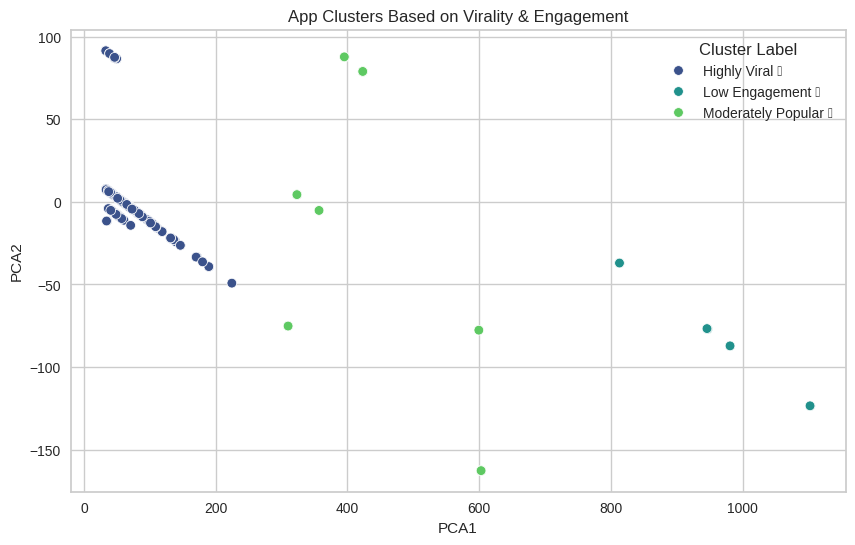

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster Label', data=df, palette='viridis')
plt.title("App Clusters Based on Virality & Engagement")
plt.show()

In [ ]:
df.shape

(8886, 19)

In [ ]:
df['Cluster'].value_counts()

,count
Cluster,
3,8517
0,269
4,70
1,21
2,9


In [ ]:
silhouette_avg = silhouette_score(df_scaled, df['Cluster'])
print(f"Silhouette Score: {silhouette_avg:.2f}")

Silhouette Score: 0.91


# Documentation and Reporting
Documentation and Reporting for Google Play Store App Analysis

Introduction
This report details an analysis of the Google Play Store app dataset to understand factors driving app success.  We explored app ratings, reviews, pricing, installs, and other features to provide insights for app developers.

Goals
1. Analyze app quality through ratings and reviews.
2. Understand the relationship between pricing (free vs. paid) and downloads.
3. Identify popular app categories based on installs and ratings.
4. Examine the effect of app size, updates, and Android version compatibility on performance.


Data Understanding and Preparation
The dataset was loaded and inspected for initial understanding. Data cleaning steps included handling duplicates, converting data types (installs, size, price), and addressing missing values.


Feature Engineering
Two new features were engineered to capture user engagement and virality:
* **Engagement Score**: Reviews / Installs * 100
* **Virality Score**: (log(Reviews) * Rating) / log(Installs)

These scores were added to the dataset for further analysis.

Clustering with K-Means
We used the K-means clustering algorithm to segment apps into virality clusters. The optimal number of clusters was determined using the Elbow method. Features were scaled before clustering to prevent bias.  Five clusters were chosen and labeled as:

* Highly Viral 🚀
* Moderately Popular 📈
* Low Engagement 📉

Dimensionality Reduction with PCA
Principal Component Analysis (PCA) was employed to reduce the number of dimensions to two for visualization. The clusters were then plotted on a 2D scatterplot, revealing the distribution of apps across the virality landscape.


Evaluation
The Silhouette Score was calculated to evaluate the quality of the clusters generated by the K-means algorithm. The silhouette score measures how similar a data point is to its own cluster (cohesion) compared to other clusters (separation).


Conclusion
The analysis identifies patterns in app virality, suggesting strategies for app developers to improve user engagement.  The visualization of the clusters, with the aid of PCA, offers a clearer understanding of where apps stand in the market.

Further analysis could include a deeper dive into specific app categories and the impact of different factors (e.g., size, updates).  The created virality and engagement scores provide excellent metrics to measure app performance.